In [1]:
from __future__ import print_function

import torch
import torch.utils.data as data
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
from torch.utils.data.dataset import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from torch.nn import Parameter
from torch.autograd import Variable

import torchvision
from torchvision import datasets
import torchvision.transforms as transforms

import time
import datetime
import math, cv2, os, sys
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

%matplotlib inline

In [2]:
class BBBConv2d(nn.Module):
    def __init__(self, q_logvar_init, p_logvar_init, in_channels, out_channels, kernel_size, 
                 stride=1, padding=0, dilation=1, groups=1, bias=False):
        super(BBBConv2d, self).__init__()
        if in_channels % groups != 0:
            raise ValueError('in_channels must be divisible by groups')
        if out_channels % groups != 0:
            raise ValueError('out_channels must be divisible by groups')
        self.q_logvar_init = q_logvar_init
        self.p_logvar_init = p_logvar_init
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.dilation = dilation
        self.groups = groups
        self.bias = bias

        self.mu_weight = Parameter(torch.Tensor(out_channels, 
                                                in_channels // groups, 
                                                kernel_size, 
                                                kernel_size))
        self.sigma_weight = Parameter(torch.Tensor(out_channels,
                                                   in_channels // groups, 
                                                   kernel_size, 
                                                   kernel_size))
        self.register_buffer('eps_weight', torch.Tensor(out_channels, 
                                                        in_channels // groups, 
                                                        kernel_size, 
                                                        kernel_size))
        
        self.reset_parameters()

    def reset_parameters(self):
        n = self.in_channels
        n *= self.kernel_size ** 2
        stdv = 1.0 / math.sqrt(n)
        self.mu_weight.data.uniform_(-stdv, stdv)
        self.sigma_weight.data.fill_(self.p_logvar_init)

    def forward(self, input):
        raise NotImplementedError()


    def convprobforward(self, input):
        sig_weight = torch.exp(self.sigma_weight)
        weight = self.mu_weight + sig_weight * self.eps_weight.normal_()
        kl_ = math.log(self.q_logvar_init) - self.sigma_weight + (sig_weight**2 + self.mu_weight**2) / (2 * self.q_logvar_init ** 2) - 0.5
        bias = None
        
        out = F.conv2d(input, weight, bias, self.stride, self.padding, self.dilation, self.groups)
        kl = kl_.sum() 
        return out, kl  

In [3]:
class BBBLinearFactorial(nn.Module):
    def __init__(self, q_logvar_init, p_logvar_init, in_features, out_features, bias=False):
        super(BBBLinearFactorial, self).__init__()
        self.q_logvar_init = q_logvar_init
        self.in_features = in_features
        self.out_features = out_features
        self.p_logvar_init = p_logvar_init
        self.mu_weight = Parameter(torch.Tensor(out_features, in_features))
        self.sigma_weight = Parameter(torch.Tensor(out_features, in_features))
        self.register_buffer('eps_weight', torch.Tensor(out_features, in_features))
        
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.mu_weight.size(1))
        self.mu_weight.data.uniform_(-stdv, stdv)
        self.sigma_weight.data.fill_(self.p_logvar_init)
        self.eps_weight.data.zero_()

    def forward(self, input):
        raise NotImplementedError()
        

    def fcprobforward(self, input):
        sig_weight = torch.exp(self.sigma_weight)
        weight = self.mu_weight + sig_weight * self.eps_weight.normal_()
        kl_ = math.log(self.q_logvar_init) - self.sigma_weight + (sig_weight**2 + self.mu_weight**2) / (2 * self.q_logvar_init ** 2) - 0.5
        bias = None
        out = F.linear(input, weight, bias)
        kl = kl_.sum() 
        return out, kl



In [4]:
class FlattenLayer(nn.Module):
    def __init__(self, num_features):
        super(FlattenLayer, self).__init__()
        self.num_features = num_features

    def forward(self, x):
        return x.view(-1, self.num_features)


class GaussianVariationalInference(nn.Module):
    def __init__(self, loss=nn.CrossEntropyLoss()):
        super(GaussianVariationalInference, self).__init__()
        self.loss = loss

    def forward(self, logits, y, kl, beta):
        logpy = self.loss(logits, y)

        loss = logpy + beta * kl  # ELBO

        return loss  


In [5]:
class BBBAlexNet(nn.Module):
    '''The architecture of AlexNet with Bayesian Layers'''

    def __init__(self, outputs, inputs):
        super(BBBAlexNet, self).__init__()

        self.p_logvar_init = 0.05
        self.q_logvar_init = math.log(0.05)


        self.conv1 = BBBConv2d(self.p_logvar_init, self.q_logvar_init, inputs, 64, kernel_size=11, stride=4, padding=5)
        self.soft1 = nn.Softplus()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = BBBConv2d(self.p_logvar_init, self.q_logvar_init, 64, 192, kernel_size=5, padding=2)
        self.soft2 = nn.Softplus()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = BBBConv2d(self.p_logvar_init, self.q_logvar_init, 192, 384, kernel_size=3, padding=1,)
        self.soft3 = nn.Softplus()

        self.conv4 = BBBConv2d(self.p_logvar_init, self.q_logvar_init, 384, 256, kernel_size=3, padding=1,)
        self.soft4 = nn.Softplus()

        self.conv5 = BBBConv2d(self.p_logvar_init, self.q_logvar_init, 256, 128, kernel_size=3, padding=1,)
        self.soft5 = nn.Softplus()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.flatten = FlattenLayer(1 * 1 * 128)
        self.fc1 = BBBLinearFactorial( self.p_logvar_init, self.q_logvar_init, 1* 1 * 128, outputs,)


        layers = [self.conv1, self.soft1, self.pool1, self.conv2, self.soft2, self.pool2, self.conv3, self.soft3,
                  self.conv4, self.soft4, self.conv5, self.soft5, self.pool3, self.flatten, self.fc1]

        self.layers = nn.ModuleList(layers)

    def probforward(self, x):
        'Forward pass with Bayesian weights'
        kl = 0
        for layer in self.layers:
            if hasattr(layer, 'convprobforward') and callable(layer.convprobforward):
                x, _kl, = layer.convprobforward(x)
                kl += _kl

            elif hasattr(layer, 'fcprobforward') and callable(layer.fcprobforward):
                x, _kl, = layer.fcprobforward(x)
                kl += _kl
            else:
                x = layer(x)
        logits = x
        return logits, kl


In [6]:
def conv_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        #nn.init.xavier_uniform(m.weight, gain=np.sqrt(2))
        nn.init.normal_(m.weight, mean=0, std=1)
        nn.init.constant(m.bias, 0)

class AlexNet(nn.Module):
    def __init__(self, num_classes, inputs=3):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(inputs, 64, kernel_size=11, stride=4, padding=5),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [7]:
class advData(Dataset):
    def __init__(self, root_path, transform=None):
        super(advData, self).__init__()
        data_list = os.listdir(root_path)
        imgs = []
        for item in data_list:
            img_path = os.path.join(root_path, item)
            labels = item.split('.')[0]
            labels = labels.split('_')[1]
            imgs.append((img_path, int(labels)))

        self.imgs = imgs
        self.transform = transform

    def __getitem__(self, index):
        if torch.is_tensor(index):
            index = index.tolist()
        img, label = self.imgs[index]
        image = Image.open(img)
        #image = cv2.imread(img)
        #image = np.transpose(image, (2, 0, 1))
        #image = image.astype(np.float32)
        #b, g, r = cv2.split(image)
        #image = cv2.merge([r, g, b])
        if self.transform is not None:
            image = self.transform(image)
        return image, label

    def __len__(self):
        return len(self.imgs)

In [8]:
net_type = 'alexnet'
dataset = 'CIFAR10'
outputs = 10
inputs = 3
resume = False
n_epochs = 40
lr = 0.001
weight_decay = 0.0005
num_samples = 1
beta_type = "Blundell"
resize=32
adv_path = './dataset/advCIFAR10'

num_workers = 2
batch_size = 128
valid_size = 0.2

classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

In [9]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(), 
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

train_data = datasets.CIFAR10('/home/cyp/data/CIFAR10', train=True, download=True, transform=transform)

#train_data = advData(adv_path, transform=transform)

test_data = datasets.CIFAR10('/home/cyp/data/CIFAR10', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [10]:
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

In [11]:
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           sampler=train_sampler, num_workers=num_workers)

valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           sampler=valid_sampler, num_workers=num_workers)

test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
                                          num_workers=num_workers)

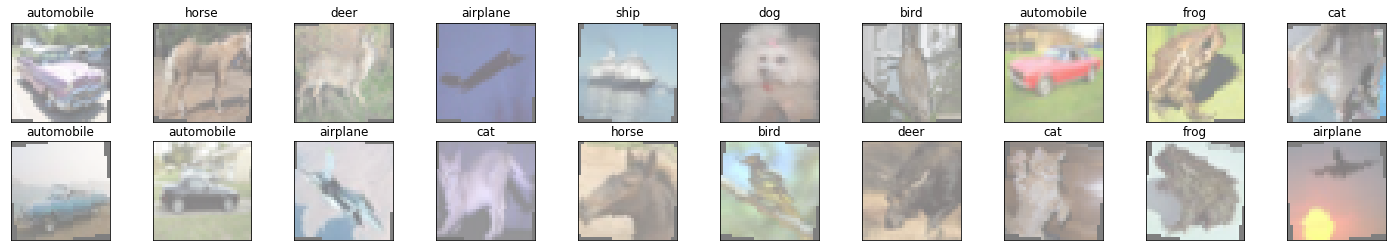

In [12]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

In [13]:
use_cuda = torch.cuda.is_available()
torch.cuda.set_device(0)


# Bayesian AlexNet CIFAR10

In [14]:
net_bay = BBBAlexNet(outputs,inputs)

vi = GaussianVariationalInference(torch.nn.CrossEntropyLoss())
optimizer = optim.Adam(net_bay.parameters(), lr=lr, weight_decay=weight_decay)

In [15]:
ckpt_name_bay = f'model_{net_type}_{dataset}_bayesian_bay.pt'
ckpt_name_bay

'model_alexnet_CIFAR10_bayesian_bay.pt'

In [16]:
%%time

if use_cuda:
    net_bay.cuda()
valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    m = math.ceil(len(train_data) / batch_size)
    
    ###################
    # train the model #
    ###################
    net_bay.train()
    for batch_idx, batch_data in enumerate(train_loader, 0):
        # move tensors to GPU if CUDA is available
        
        data, target = batch_data
        data = data.view(-1, inputs, resize, resize).repeat(num_samples, 1, 1, 1)
        target = target.repeat(num_samples)
        if use_cuda:
            data, target = data.cuda(), target.cuda()
            
        if beta_type is "Blundell":
            beta = 2 ** (m - (batch_idx + 1)) / (2 ** m - 1)
        elif beta_type is "Soenderby":
            beta = min(epoch / (num_epochs // 4), 1)
        elif beta_type is "Standard":
            beta = 1 / m
        else:
            beta = 0
            
            
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output,kl = net_bay.probforward(data)
        loss = vi(output, target, kl, beta)
        loss.backward()
        optimizer.step()
        train_loss += (loss.item()*data.size(0)) / num_samples
        
    ######################    
    # validate the model #
    ######################
    net_bay.eval()
    for batch_idx, valid_data in enumerate(valid_loader, 0):
        data, target = valid_data
        data = data.view(-1, inputs, resize, resize).repeat(num_samples, 1, 1, 1)
        target = target.repeat(num_samples)
        # move tensors to GPU if CUDA is available
        if use_cuda:
            data, target = data.cuda(), target.cuda()

        output,kl = net_bay.probforward(data)
        loss = vi(output, target, kl, beta)
        valid_loss += (loss.item()*data.size(0)) / num_samples
        
    train_loss = train_loss/(len(train_loader.dataset) * (1-valid_size))
    valid_loss = valid_loss/(len(valid_loader.dataset) * valid_size)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
    torch.save(net_bay.state_dict(), ckpt_name_bay)
    valid_loss_min = valid_loss


Epoch: 1 	Training Loss: 199.641644 	Validation Loss: 2.672166
Validation loss decreased (inf --> 2.672166).  Saving model ...
Epoch: 2 	Training Loss: 692.540254 	Validation Loss: 2.544414
Validation loss decreased (2.672166 --> 2.544414).  Saving model ...
Epoch: 3 	Training Loss: 689.902045 	Validation Loss: 2.447326
Validation loss decreased (2.544414 --> 2.447326).  Saving model ...
Epoch: 4 	Training Loss: 711.994718 	Validation Loss: 2.500166
Epoch: 5 	Training Loss: 708.982871 	Validation Loss: 2.458940
Validation loss decreased (2.500166 --> 2.458940).  Saving model ...
Epoch: 6 	Training Loss: 700.405257 	Validation Loss: 2.477550
Epoch: 7 	Training Loss: 662.055575 	Validation Loss: 2.424206
Validation loss decreased (2.477550 --> 2.424206).  Saving model ...
Epoch: 8 	Training Loss: 623.200025 	Validation Loss: 2.459110
Epoch: 9 	Training Loss: 587.517147 	Validation Loss: 2.422552
Validation loss decreased (2.459110 --> 2.422552).  Saving model ...
Epoch: 10 	Training Loss

Epoch: 84 	Training Loss: 481.802143 	Validation Loss: 2.382507
Epoch: 85 	Training Loss: 481.309475 	Validation Loss: 2.368008
Validation loss decreased (2.382507 --> 2.368008).  Saving model ...
Epoch: 86 	Training Loss: 481.625383 	Validation Loss: 2.402767
Epoch: 87 	Training Loss: 481.344258 	Validation Loss: 2.369932
Validation loss decreased (2.402767 --> 2.369932).  Saving model ...
Epoch: 88 	Training Loss: 481.895964 	Validation Loss: 2.396921
Epoch: 89 	Training Loss: 481.583623 	Validation Loss: 2.360986
Validation loss decreased (2.396921 --> 2.360986).  Saving model ...
Epoch: 90 	Training Loss: 482.040217 	Validation Loss: 2.411792
Epoch: 91 	Training Loss: 481.083319 	Validation Loss: 2.374139
Validation loss decreased (2.411792 --> 2.374139).  Saving model ...
Epoch: 92 	Training Loss: 481.448032 	Validation Loss: 2.397310
Epoch: 93 	Training Loss: 481.445283 	Validation Loss: 2.369211
Validation loss decreased (2.397310 --> 2.369211).  Saving model ...
Epoch: 94 	Trai

In [17]:
net_bay.load_state_dict(torch.load(ckpt_name_bay))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [18]:
%%time

if use_cuda:
    net_bay.cuda()


test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

net_bay.eval()
m = math.ceil(len(test_data) / batch_size)

for batch_idx, test_data in enumerate(test_loader, 0):
    data, target = test_data
    
    data = data.view(-1, inputs, resize, resize).repeat(num_samples, 1, 1, 1)
    target = target.repeat(num_samples)
    if use_cuda:
        data, target = data.cuda(), target.cuda()
    
    if beta_type is "Blundell":
        beta = 2 ** (m - (batch_idx + 1)) / (2 ** m - 1)
    elif cf.beta_type is "Soenderby":
        beta = min(epoch / (cf.num_epochs // 4), 1)
    elif cf.beta_type is "Standard":
        beta = 1 / m
    else:
        beta = 0

    output, kl = net_bay.probforward(data)

    loss = vi(output, target, kl, beta)

    test_loss += loss.item()*data.size(0) / num_samples
    _, pred = torch.max(output, 1) 
    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not use_cuda else np.squeeze(correct_tensor.cpu().numpy())
    for i in range(batch_size):
        if i >= target.data.shape[0]: # batch_size could be greater than left number of images
            break
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1


test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))
   
print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 2134.348955

Test Accuracy of airplane:  5% (53/1000)
Test Accuracy of automobile:  3% (35/1000)
Test Accuracy of  bird: 10% (100/1000)
Test Accuracy of   cat: 10% (108/1000)
Test Accuracy of  deer: 11% (110/1000)
Test Accuracy of   dog:  8% (84/1000)
Test Accuracy of  frog: 12% (127/1000)
Test Accuracy of horse: 12% (128/1000)
Test Accuracy of  ship: 11% (112/1000)
Test Accuracy of truck: 11% (115/1000)

Test Accuracy (Overall):  9% (972/10000)
CPU times: user 5.11 s, sys: 140 ms, total: 5.25 s
Wall time: 705 ms


# Original AlexNet CIFAR10

In [19]:
ckpt_name_ori = f'model_{net_type}_{dataset}_bayesian_ori.pt'
ckpt_name_ori

'model_alexnet_CIFAR10_bayesian_ori.pt'

In [20]:
net_ori = AlexNet(10)
net_ori.apply(conv_init)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net_ori.parameters(), lr=lr)

/home/cyp/anaconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  


In [21]:
%%time
if use_cuda:
    net_ori.cuda()

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    net_ori.train()
    for i, batch_data in enumerate(train_loader, 0):
        data, target = batch_data
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        output = net_ori(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    net_ori.eval()
    for i, valid_data in enumerate(valid_loader, 0):
        data, target = valid_data
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = net_ori(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(net_ori.state_dict(), ckpt_name_ori)
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 656711.201490 	Validation Loss: 1708.448028
Validation loss decreased (inf --> 1708.448028).  Saving model ...
Epoch: 2 	Training Loss: 14859.147235 	Validation Loss: 208.250444
Validation loss decreased (1708.448028 --> 208.250444).  Saving model ...
Epoch: 3 	Training Loss: 1869.965256 	Validation Loss: 69.150952
Validation loss decreased (208.250444 --> 69.150952).  Saving model ...
Epoch: 4 	Training Loss: 1444.526073 	Validation Loss: 76.428094
Epoch: 5 	Training Loss: 1021.363265 	Validation Loss: 50.037268
Validation loss decreased (69.150952 --> 50.037268).  Saving model ...
Epoch: 6 	Training Loss: 606.996637 	Validation Loss: 27.386660
Validation loss decreased (50.037268 --> 27.386660).  Saving model ...
Epoch: 7 	Training Loss: 326.199303 	Validation Loss: 17.672212
Validation loss decreased (27.386660 --> 17.672212).  Saving model ...
Epoch: 8 	Training Loss: 170.327479 	Validation Loss: 11.674407
Validation loss decreased (17.672212 --> 11.674407)

KeyboardInterrupt: 

In [22]:
net_ori.load_state_dict(torch.load(ckpt_name_ori))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [23]:
%%time

if use_cuda:
    net_ori.cuda()
# track test loss# track  
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

net_ori.eval()

for i, test_data in enumerate(test_loader, 0):
    data, target = test_data
    if use_cuda:
        data, target = data.cuda(), target.cuda()

    output = net_ori(data)

    loss = criterion(output, target)
    test_loss += loss.item()*data.size(0)

    _, pred = torch.max(output, 1)    

    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not use_cuda else np.squeeze(correct_tensor.cpu().numpy())
    
    # calculate test accuracy for each object class
    for i in range(batch_size):
        if i >= target.data.shape[0]: # batch_size could be greater than left number of images
            break
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 2.302635

Test Accuracy of airplane:  0% ( 0/1000)
Test Accuracy of automobile: 100% (1000/1000)
Test Accuracy of  bird:  0% ( 0/1000)
Test Accuracy of   cat:  0% ( 0/1000)
Test Accuracy of  deer:  0% ( 0/1000)
Test Accuracy of   dog:  0% ( 0/1000)
Test Accuracy of  frog:  0% ( 0/1000)
Test Accuracy of horse:  0% ( 0/1000)
Test Accuracy of  ship:  0% ( 0/1000)
Test Accuracy of truck:  0% ( 0/1000)

Test Accuracy (Overall): 10% (1000/10000)
CPU times: user 695 ms, sys: 157 ms, total: 852 ms
Wall time: 891 ms


In [ ]:
train_data = datasets.CIFAR100('/home/cyp/data/CIFAR100', train=True, download=True, transform=transform)

#train_data = advData(adv_path, transform=transform)

test_data = datasets.CIFAR100('/home/cyp/data/CIFAR100', train=False, download=True, transform=transform)

Failed download. Trying https -> http instead. Downloading http://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz to /home/cyp/data/CIFAR100/cifar-100-python.tar.gz
